# Cryosphere model Comparison tool (CmCt) Dynamic Thickness Tool

In [1]:
import numpy as np
import h5py
import pyproj
import cartopy.crs as ccrs
import time
from datetime import datetime
import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

## Documentation and Input Data Requirements

Time, dh, x and y variables. ISMIP6 map. Currently time in string, not cftime

Year requirements

Information about partial map and where residual will be NaN

Information about pipeline

Information about output netcdf

## Inputs

In [2]:
# Observation data
obs_dir = "observation_data/"
obs_fn = "Dynamic_h_Greenland_IMAU_1994_2020.nc"
obs_path = obs_dir + obs_fn

# Model data
model_dir = "model_files/"
model_fn = "gris.proj.2007-2015.A1091.dhdynAnom6079.nc"
model_path = model_dir + model_fn

# Desired balance year for comparison: year = "1995" means that the model and observation dh will be 
# compared for Sep 1st 1994 to Sep 1st 1995. Note that this cannot be before 1995 or the first year for 
# which data is defined in the model, nor can it be after 2021 or the last year for which data is defined
# in the model
year = "2007"   # YYYY

# Output filename in which to store residuals
output_dir = "output_files/"
output_fn = "temp_res"
output_fn = output_dir + output_fn + ".nc"

## Read in Observation Data

In [3]:
def read_obs_file(obs_path, year):
    global x_UTM
    global y_UTM
    global crs_wkt
    
    with h5py.File(obs_path, mode='r') as f:
        x_UTM = f['x'][:]
        y_UTM = f['y'][:]

        # If time[i] is equal to '1995', dh[i,:,:] represents the balance year from Sep 1st 1994 to Sep 1st 1995
        time_obs = (f['time'][:]).astype("str")
        
        dh = f['dh'][:]
        
        spatial_ref = f['spatial_ref']
        crs_wkt = spatial_ref.attrs['crs_wkt'].decode('UTF-8')

    # Check desired comparison year works for observation data
    year_dt = datetime.strptime(year, "%Y")
    if datetime.strptime(time_obs[0], "%Y") > year_dt:
        print(f"Error: Desired comparison year ({year}) occurs before first date of observation data ({time_obs[0]})")
        return None
        
    if datetime.strptime(time_obs[-1], "%Y") < year_dt:
        print(f"Error: Desired comparison year ({year}) occurs after last date of observation data ({time_obs[-1]})")
        return None

    # Find the dh in the year specified
    time_idx = np.argwhere(time_obs == year)[0,0]
    dh_obs = dh[time_idx, :, :]
    return dh_obs

## Read in Model Data

In [4]:
def read_model_file(model_path, year):
    global x_mod
    global y_mod

    with h5py.File(model_path, mode='r') as f:
        x_mod = f['x'][:]
        y_mod = f['y'][:]

        # If time[i] is equal to '1995', dh[i,:,:] represents the balance year from Sep 1st 1994 to Sep 1st 1995
        time_mod = f['t'][:]      #TEMPORARY: CHANGE TO time
        time_mod = np.array([str(int(t)) for t in time_mod])
        
        dh = f['dh_dynAnom'][:]   #TEMPORARY: CHANGE TO dh 

    # Check desired comparison year works for model data
    year_dt = datetime.strptime(year, "%Y")
    if datetime.strptime(time_mod[0], "%Y") > year_dt:
        print(f"Error: Desired comparison year ({year}) occurs before first date of model data ({time_mod[0]})")
        return None
        
    if datetime.strptime(time_mod[-1], "%Y") < year_dt:
        print(f"Error: Desired comparison year ({year}) occurs after last date of model data ({time_mod[-1]})")
        return None

    # Find the dh in the year specified
    time_idx = np.argwhere(time_mod == year)[0,0]
    dh_mod = dh[time_idx, :, :]
    return dh_mod

## Transform Observation Coordinates from UTM-24N to ISMIP6 polar-stereographic coordinates

In [5]:
def transform_obs_coords(crs_wkt, x_UTM, y_UTM, dh_obs):     #TEMPORARY: REMOVE DH_OBS INPUT
    # Make a transformer from observation coordinates to model coordinatea
    crs_utm = pyproj.crs.CRS.from_wkt(crs_wkt)    # Coordinate system of observation data
    crs_ps = pyproj.crs.CRS(ccrs.Stereographic(central_latitude= 90.0, central_longitude= -45.0, false_easting= 0.0, 
                                           false_northing= 0.0, true_scale_latitude= 70.0, globe=ccrs.Globe('WGS84'))) # ISMIP6 coord sys
    utm_to_ps = pyproj.Transformer.from_crs(crs_from = crs_utm, crs_to = crs_ps)


    # Format observation coordinate data into a set of points
    xv, yv = np.meshgrid(x_UTM, y_UTM)
    x_UTM_points, y_UTM_points = xv.transpose().flatten(), yv.transpose().flatten()

    # Transform observation coordinate points to points in polar-stereographic space
    x_obs, y_obs = utm_to_ps.transform(x_UTM_points, y_UTM_points)
    return x_obs, y_obs

## Interpolate Model Data to Observation Points

In [6]:
def bilinear_interp(x, y, arr, x_query, y_query):
    """
    Bilinearly interpolates the value of arr, defined on a rectangular grid by x and y, at the set of points defined 
    by x_query and y_query. x, y, x_query, and y_query must all be in the same coordinate system.

    Parameters:
    arr: An array of floats of shape (ny, nx)
    x, y: x has shape (nx,) and y has shape (ny,). The entry arr[i][j] corresponds to the point in space defined by 
    y[i] and x[j]. The entries of x and y must be evenly spaced
    x_query, y_query: Both must have shape (n,), where n is the number of query points. It is assumed that x, y, 
    x_query, and y_query are defined in the same coordinate system and that x and x_query represent the same dimension, 
    while y and y_query represent the other dimension 

    Returns: 
    arr_query: An array of floats of shape (n,). arr_query[i] represents the estimated value of arr at the position 
    defined by x_query[i] and y_query[i], estimated using bilinear interpolation. If any query point i is outside the 
    bounds defined by x and y, arr_query[i] will be NaN
    """

    # Query points
    x_query = np.asarray(x_query)
    y_query = np.asarray(y_query)

    # Find the spacing of the x and y arrays
    sx, sy = x[1] - x[0], y[1] - y[0]
    a = sx * sy  # area of each grid cell

    # Find the indices of the four closest points in arr to each query point
    x0 = np.floor((x_query - x[0]) / sx).astype(int)   # Left
    x1 = x0 + 1                                        # Right
    y0 = np.floor((y_query - y[0]) / sy).astype(int)   # Bottom
    y1 = y0 + 1                                        # Top

    # ma[i] is True if both x_query[i] and y_query[i] are within the bounds of the grid defined by x and y
    ma = (x0 >= 0) & (x1 < len(x)) & (y0 >= 0) & (y1 < len(y))

    # Values at each of the reference coordinates
    Ia, Ib, Ic, Id = (np.empty_like(x_query, dtype=np.float64), np.empty_like(x_query, dtype=np.float64),
                     np.empty_like(x_query, dtype=np.float64), np.empty_like(x_query, dtype=np.float64))  # Allocate memory
    Ia[~ma], Ib[~ma], Ic[~ma], Id[~ma] = np.nan, np.nan, np.nan, np.nan    # Set to NaN where x or y are out of bounds
    Ia[ma] = arr[ y0[ma], x0[ma] ]    # Bottom left
    Ib[ma] = arr[ y1[ma], x0[ma] ]    # Top left
    Ic[ma] = arr[ y0[ma], x1[ma] ]    # Bottom right
    Id[ma] = arr[ y1[ma], x1[ma] ]    # Top right

    # Weights for each reference coordinate
    wa, wb, wc, wd = (np.empty_like(x_query, dtype=np.float64), np.empty_like(x_query, dtype=np.float64),
                     np.empty_like(x_query, dtype=np.float64), np.empty_like(x_query, dtype=np.float64))  # Allocate memory
    wa[~ma], wb[~ma], wc[~ma], wd[~ma] = np.nan, np.nan, np.nan, np.nan    # Set to NaN where x or y are out of bounds
    wa[ma] = ((x[x1[ma]] - x_query[ma]) * (y[y1[ma]] - y_query[ma])) / a
    wb[ma] = ((x[x1[ma]] - x_query[ma]) * (y_query[ma] - y[y0[ma]])) / a
    wc[ma] = ((x_query[ma] - x[x0[ma]]) * (y[y1[ma]] - y_query[ma])) / a
    wd[ma] = ((x_query[ma] - x[x0[ma]]) * (y_query[ma] - y[y0[ma]])) / a

    return wa*Ia + wb*Ib + wc*Ic + wd*Id     # arr_query in documentation

# Interpolate and Subtract

In [7]:
def interp_and_subtract_obs_from_model(x_obs, y_obs, dh_obs, dh_mod):
    # Only query points in the model which are not NaN for the observation (avoids unnecessary interpolation)
    I_ = (~np.isnan(dh_obs)).transpose().flatten()   # I_[i] is False if x_obs[i], y_obs[i] correspond to a point where dh_obs is NaN, True otherwise

    # Bilinearly interpolate model to observation space
    model_dh_interped_flat = bilinear_interp(x_mod, y_mod, dh_mod, x_obs[I_], y_obs[I_])

    # Reshape model array to the same shape as the observation array
    dh_mod_interped = np.empty_like(I_, dtype = np.float64)
    dh_mod_interped[~I_] = np.nan     # Fill with NaN at indices where dh_obs is NaN
    dh_mod_interped[I_] = model_dh_interped_flat
    dh_mod_interped = np.reshape(dh_mod_interped, dh_obs.shape, order = "F")

    # Residual = model - observation
    return dh_mod_interped - dh_obs

## Save to netCDF File


In [8]:
def save_residual_to_netcdf(output_fn, dh_res, x_UTM, y_UTM, year, crs_wkt):
    rootgrp = netCDF4.Dataset(output_fn, "w", format="NETCDF4")

    # Record coordinate system
    spatial_ref_var = rootgrp.createVariable("spatial_ref", "i8")
    spatial_ref_var[:] = 0
    spatial_ref_var.crs_wkt = crs_wkt

    # Set up x and y variables
    x_dim = rootgrp.createDimension("x", len(x_UTM))
    y_dim = rootgrp.createDimension("y", len(y_UTM))
    x_var = rootgrp.createVariable("x", "f4", ("x",))
    y_var = rootgrp.createVariable("y", "f4", ("y",))
    x_var[:], y_var[:] = x_UTM, y_UTM
    x_var.units, y_var.units = "meter", "meter"

    # Set up dynamic thickness residual variable
    dh_res_var = rootgrp.createVariable("dh_res", "f4", ("y","x",))
    dh_res_var[:,:] = dh_res
    dh_res_var.coordinates = "spatial_ref"
    dh_res_var.grid_mapping = "spatial_ref"
    dh_res_var.long_name = "Residual of annual dynamic mass/ice thickness (assume ice density of 917 kg/m3) change between Sep 1 of " + year + " and " + str(int(year) + 1)
    dh_res_var.units = "meters"
    rootgrp.close()

## Compute Comparison

In [9]:
def runProcessing(output_fn = output_fn):
    update_progress(0.0, "Starting...              ", 0.0)

    t = time.time()
    dh_obs = read_obs_file(obs_path, year)     # Sets global variables x_UTM, y_UTM, crs_wkt
    if dh_obs is None:
        return None
    update_progress(0.2, "Read Observation Data    ", time.time() - t)

    
    t = time.time()
    dh_mod = read_model_file(model_path, year)     # Sets global variables x_mod, y_mod
    if dh_mod is None:
        return None
    update_progress(0.4, "Read Model Data          ", time.time() - t)

    
    t = time.time()
    x_obs, y_obs,  = transform_obs_coords(crs_wkt, x_UTM, y_UTM, dh_obs)   #TEMPORARY: REMOVE DH_OBS INPUT
    update_progress(0.6, "Transformed Coordinates  ", time.time() - t)

    
    t = time.time()
    dh_res = interp_and_subtract_obs_from_model(x_obs, y_obs, dh_obs, dh_mod)
    update_progress(0.8, "Computed Residuals       ", time.time() - t)

    t = time.time()
    save_residual_to_netcdf(output_fn, dh_res, x_UTM, y_UTM, year, crs_wkt)
    update_progress(0.9, "Saved residuals to NetCDF", time.time() - t)
    
    
    print("Plotting....")
    t = time.time()
    
    # TEMPORARY
    plt.imshow(dh_obs)
    plt.title("dh_obs")
    plt.show()

    plt.imshow(dh_mod)
    plt.title("dh_mod")
    plt.show()

    plt.imshow(dh_res)
    plt.title("dh_res")
    plt.show()
    update_progress(1.0, "Plotted Results          ", time.time() - t)
    
    
    print("Success")
    return "Success"

In [10]:
# update processing progress bar
def update_progress(progress, title, time_elapsed_print):
    bar_length = 20
    block = int(20.0*progress)
    text = title+" [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100) + f" ({time_elapsed_print} seconds)"
    print(text)   

Starting...               [--------------------] 0.0% (0.0 seconds)
Read Observation Data     [####----------------] 20.0% (1.9230475425720215 seconds)
Read Model Data           [########------------] 40.0% (0.4338102340698242 seconds)
Transformed Coordinates   [############--------] 60.0% (1.2537868022918701 seconds)
Computed Residuals        [################----] 80.0% (0.529719352722168 seconds)
Saved residuals to NetCDF [##################--] 90.0% (0.1896524429321289 seconds)
Plotting....


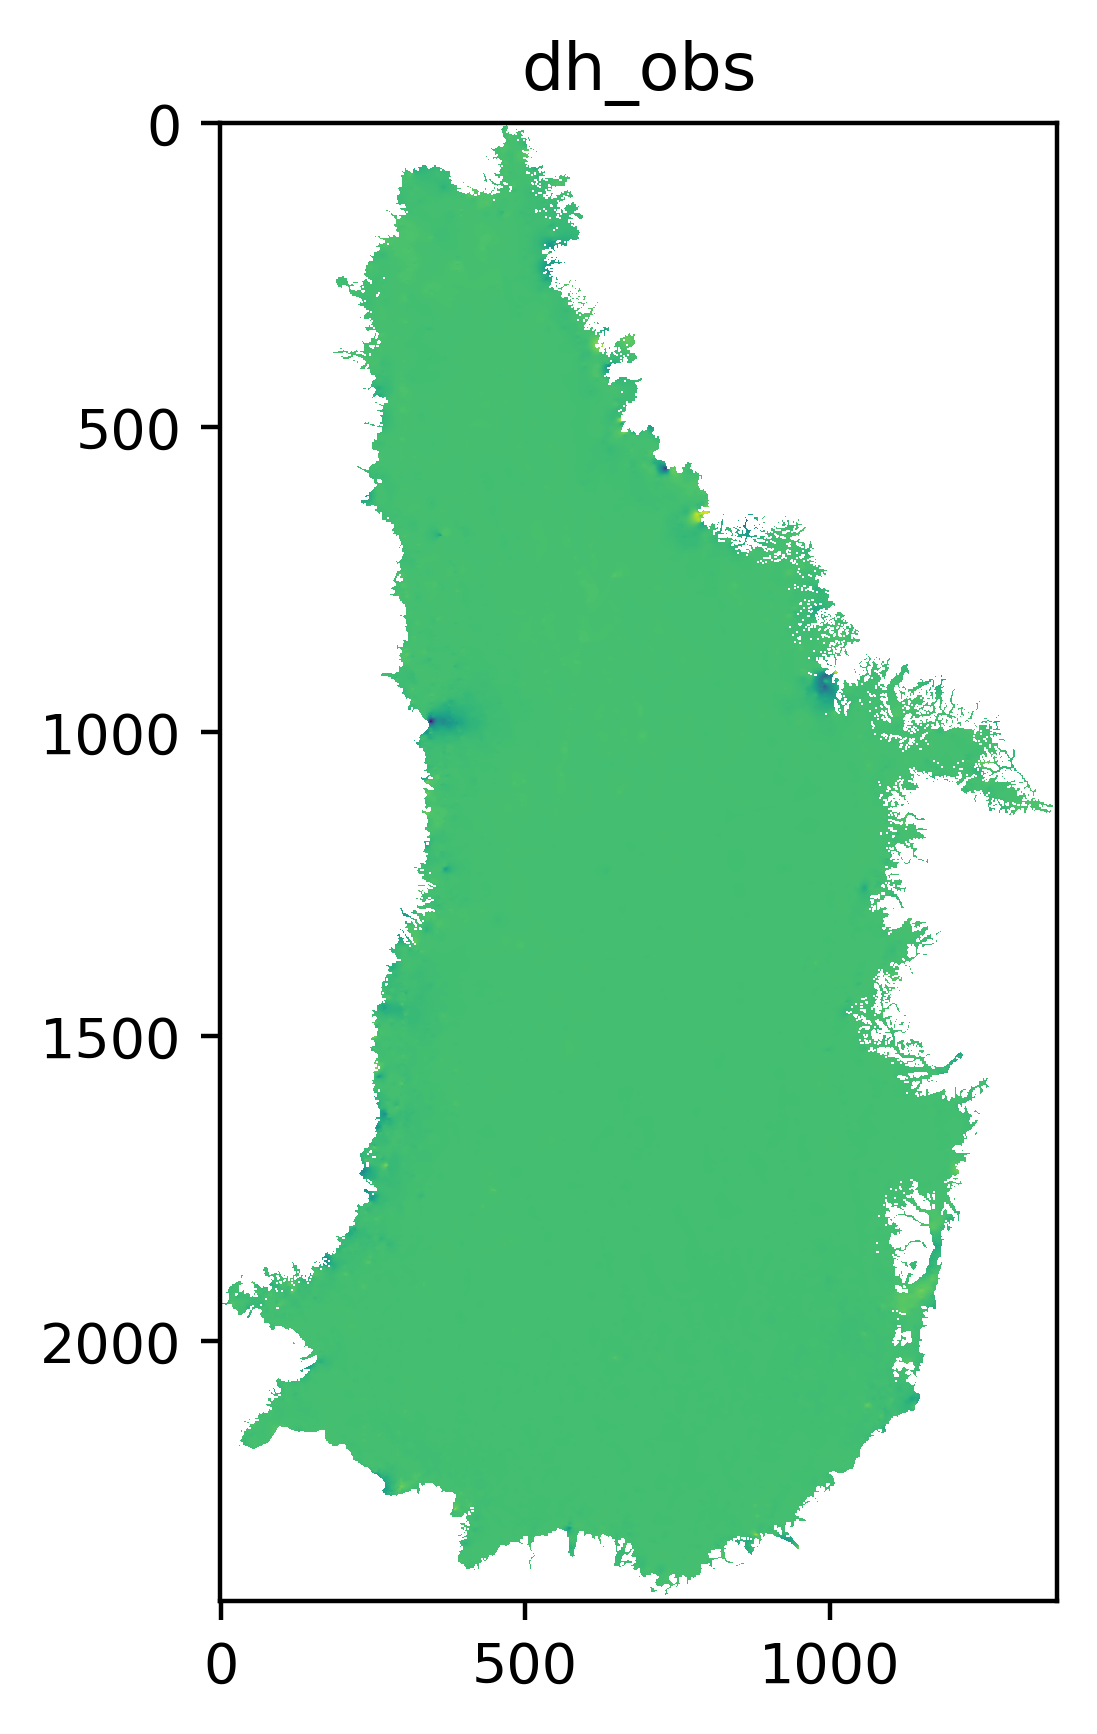

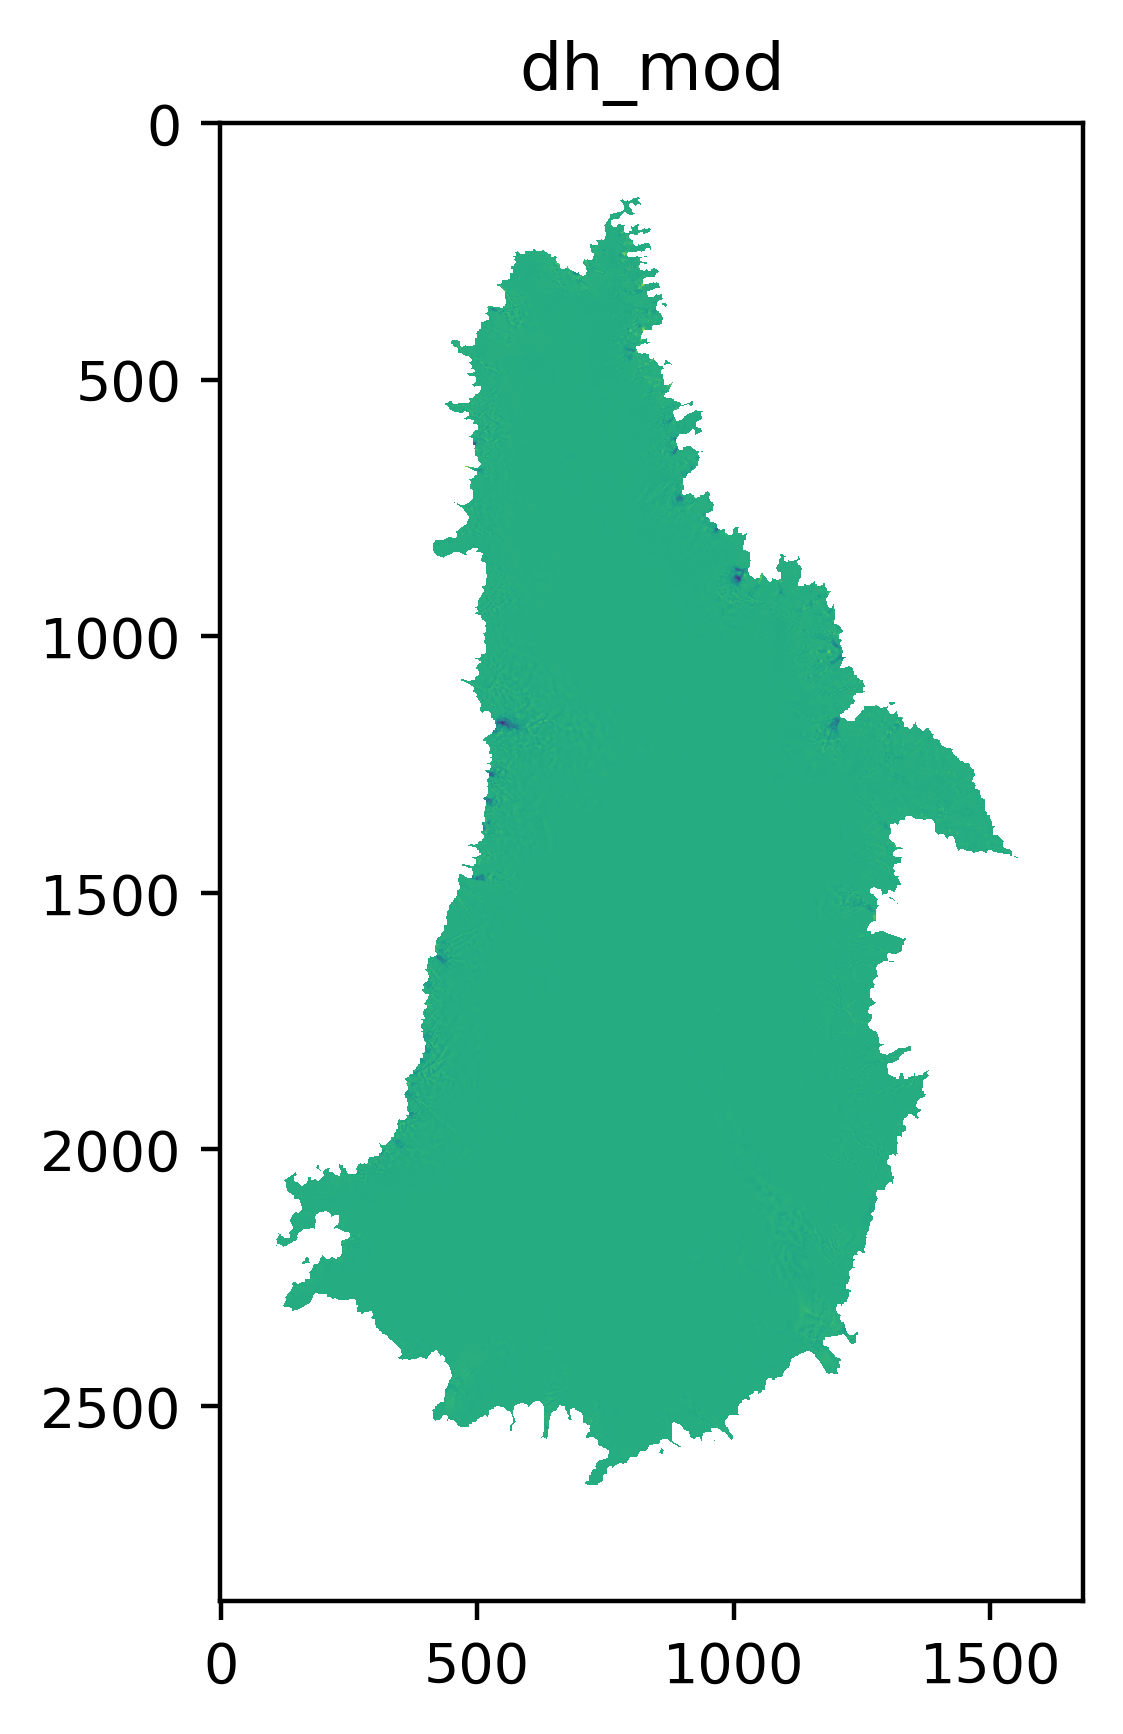

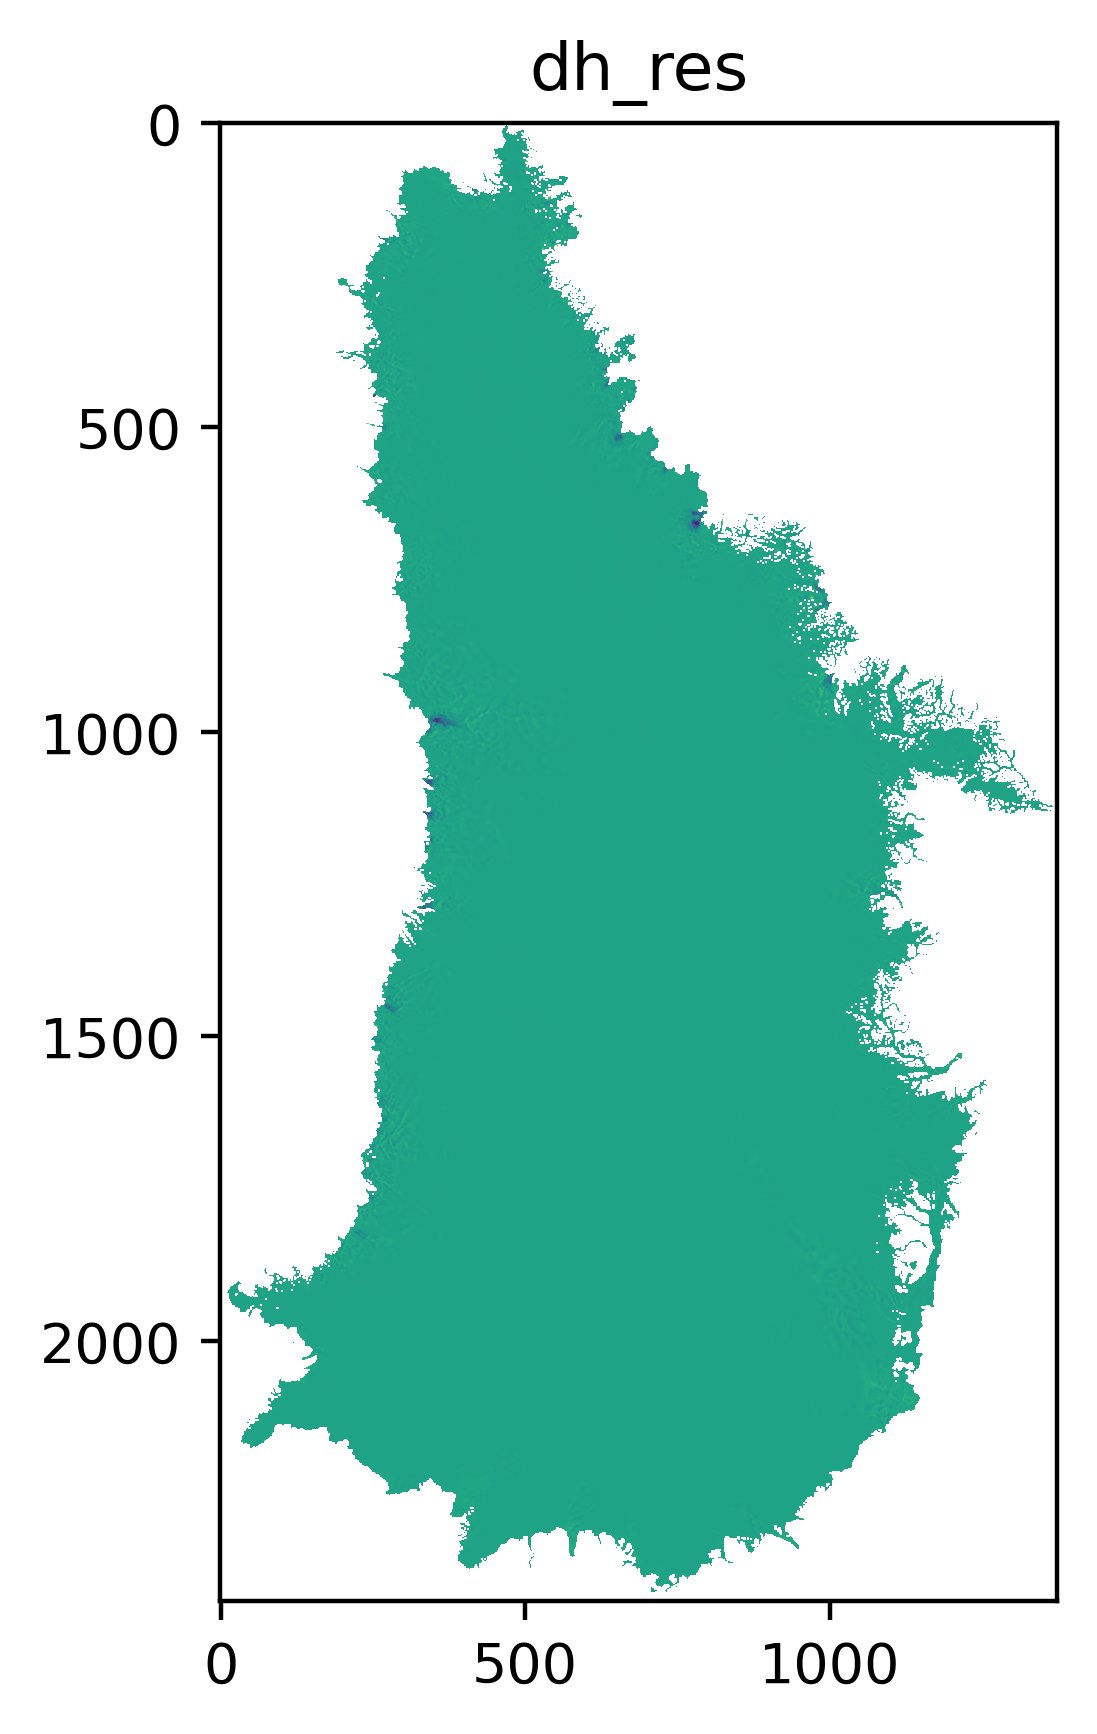

Plotted Results           [####################] 100.0% (2.2329375743865967 seconds)
Success
Total time: 6.6019814014434814 seconds


In [11]:
t_tot = time.time()
runProcessing(output_fn)
print("Total time: " + str(time.time() - t_tot) + " seconds")